<a href="https://colab.research.google.com/github/sijieh/Computer-Vision/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"irisjhuang","key":"cc0227bb56f7f3d67a2dd77d19cecf1c"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d arrowe/yoga-poses-dataset-107

Dataset URL: https://www.kaggle.com/datasets/arrowe/yoga-poses-dataset-107
License(s): unknown


In [6]:
!unzip -q yoga-poses-dataset-107.zip -d yoga_dataset

### Train two different FFN models using Keras

In [7]:
# Data for Sine model
x_sin = np.linspace(-np.pi, np.pi, 1000)
y_sin = np.sin(x_sin)

In [8]:
# Data for Custom model
x_custom = np.linspace(-np.pi, np.pi, 1000)
y_custom = np.log(np.abs(x_custom) + 1) * np.sin(2 * x_custom)

In [9]:
#Build a MLP
model = Sequential()
model.add(Input(shape=(1,)))
model.add(Dense(64, activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(1, activation='tanh'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,513 (33.25 KB)

 Trainable params: 8,513 (33.25 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from tensorflow.keras.optimizers import Adam

#  Compile the model
model.compile(optimizer=Adam(), loss='mse')

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


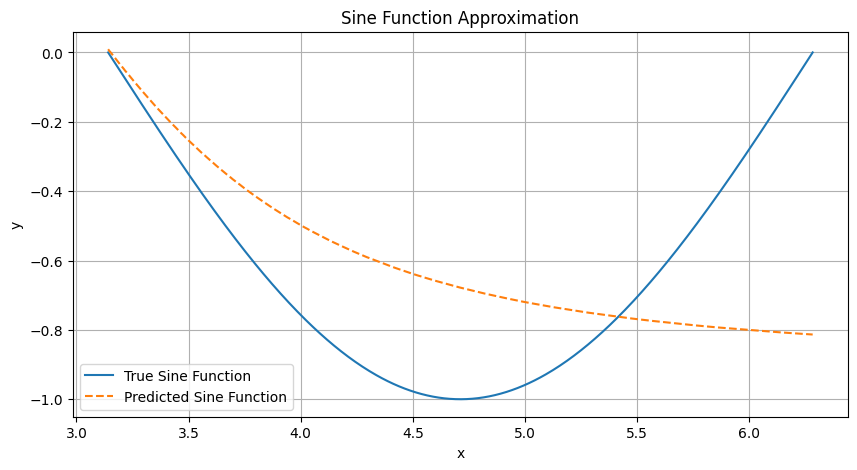

In [11]:
# Train the model on Sine data
model.fit(x_sin, y_sin, epochs=300, verbose=0)

# Predict using the trained model
x_test_sin = np.linspace(np.pi, 2*np.pi, 500)
y_test_sin_true = np.sin(x_test_sin)
y_test_sin_pred = model.predict(x_test_sin)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(x_test_sin, y_test_sin_true, label='True Sine Function')
plt.plot(x_test_sin, y_test_sin_pred, label='Predicted Sine Function', linestyle='--')
plt.title('Sine Function Approximation')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


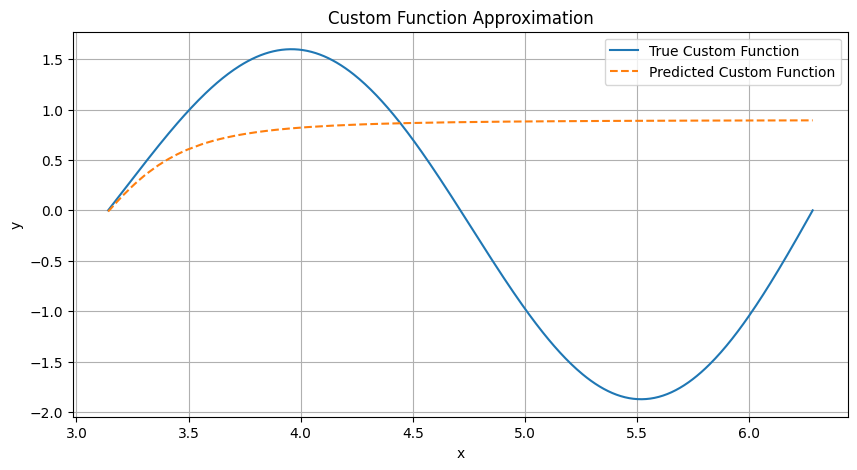

In [12]:
model.fit(x_custom, y_custom, epochs=500, verbose=0)
x_test_custom = np.linspace(np.pi, 2*np.pi, 500)
y_test_custom_true = np.log(np.abs(x_test_custom) + 1) * np.sin(2 * x_test_custom)
y_test_custom_pred = model.predict(x_test_custom)
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(x_test_custom, y_test_custom_true, label='True Custom Function')
plt.plot(x_test_custom, y_test_custom_pred, label='Predicted Custom Function', linestyle='--')
plt.title('Custom Function Approximation')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()


#### Summarize Model Architecture

Both models use:

	•	Input: 1D scalar input

	•	Hidden Layers: 2 hidden layers with 32 neurons each

	•	Activation: tanh (better for smooth, periodic data)

	•	Output: 1 neuron (tanh activation)



The term “Universal Function Approximators” refers to the idea that neural networks, specifically feedforward neural networks with at least one hidden layer and a non-linear activation function, can approximate any continuous function on a compact input domain to any desired degree of accuracy — given enough neurons.

However, the experiment doesn't support this idea because the prediction results are very different from the actual results. This might be due to the lack of training data.

### Build a deep learning model to classify yoga poses

In [13]:
%load_ext cudf.pandas
import time
import pandas as pd
import matplotlib.cm as cm

import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import to_categorical

In [14]:
import os
import seaborn as sns
from PIL import Image

data_path = "yoga_dataset/107 yoga poses"

train_dir = os.path.join(data_path, 'train')
val_dir = os.path.join(data_path, 'val')
test_dir = os.path.join(data_path, 'test')
classes = os.listdir(train_dir)
print(f"Total Classes: {len(classes)}")

Total Classes: 107


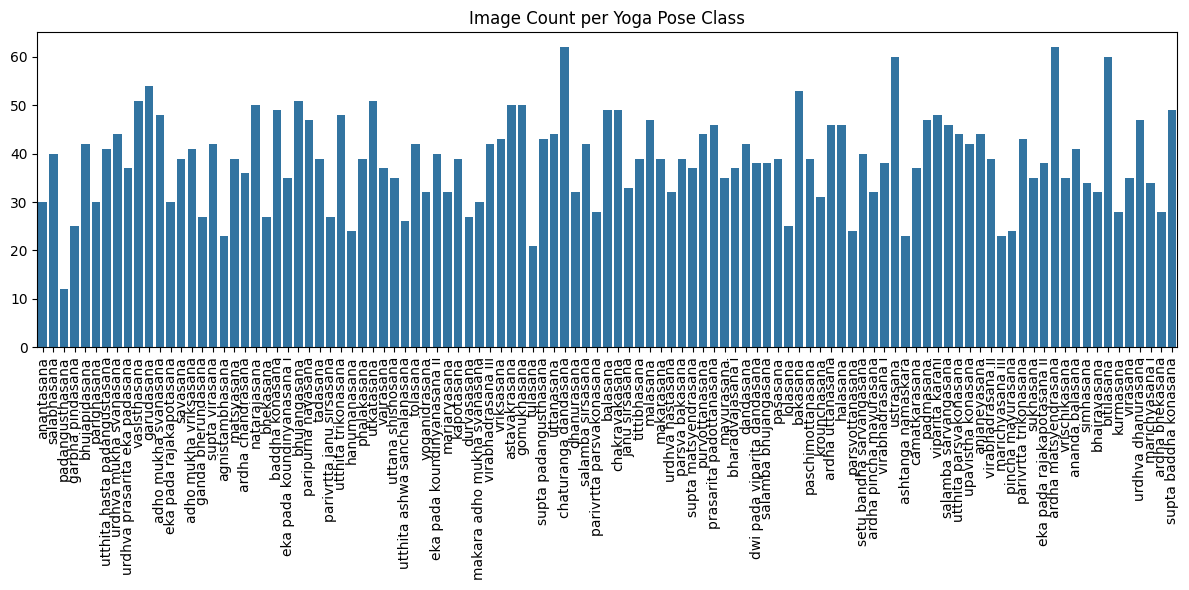

In [15]:
# Count images per class
class_counts = {cls: len(os.listdir(os.path.join(data_path, 'train', cls))) for cls in classes}
plt.figure(figsize=(12, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=90)
plt.title("Image Count per Yoga Pose Class")
plt.tight_layout()
plt.show()

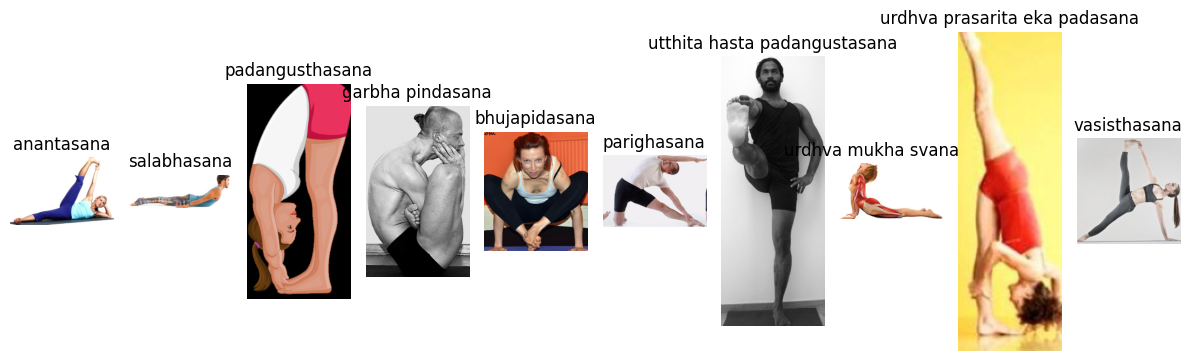

In [16]:
# Display the first few training images
plt.figure(figsize=(12, 6))
for i, cls in enumerate(classes[:10]):
    img_path = os.path.join(data_path, 'train', cls, os.listdir(os.path.join(data_path, 'train', cls))[0])
    img = Image.open(img_path)
    plt.subplot(1, 10, i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
val_gen = val_test_datagen.flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
test_gen = val_test_datagen.flow_from_directory(test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

num_classes = train_gen.num_classes

Found 4147 images belonging to 107 classes.
Found 1157 images belonging to 107 classes.
Found 687 images belonging to 107 classes.


In [18]:
# Build a basic CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(train_gen.num_classes, activation='softmax')
])

# Vanilla SGD
optimizer = SGD(learning_rate=0.01, momentum=0.0)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 127008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    16,257,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 107)            │        13,803 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,271,851 (62.07 MB)

 Trainable params: 16,271,851 (62.07 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Train the model
history_sgd = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50
)

Epoch 1/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 33s 216ms/step - accuracy: 0.0097 - loss: 4.7018 - val_accuracy: 0.0164 - val_loss: 4.6721
Epoch 2/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - accuracy: 0.0195 - loss: 4.6719 - val_accuracy: 0.0112 - val_loss: 4.6764
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - accuracy: 0.0107 - loss: 4.6707 - val_accuracy: 0.0173 - val_loss: 4.6643
Epoch 4/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - accuracy: 0.0144 - loss: 4.6594 - val_accuracy: 0.0182 - val_loss: 4.6770
Epoch 5/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - accuracy: 0.0288 - loss: 4.6363 - val_accuracy: 0.0199 - val_loss: 4.6370
Epoch 6/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - accuracy: 0.0297 - loss: 4.6055 - val_accuracy: 0.0207 - val_loss: 4.6060
Epoch 7/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - accuracy: 0.0349 - loss: 4.5653 - val_accuracy: 0.0285 - val_loss: 4.5874
Epoch 8/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - accuracy: 0.0492 - loss: 4

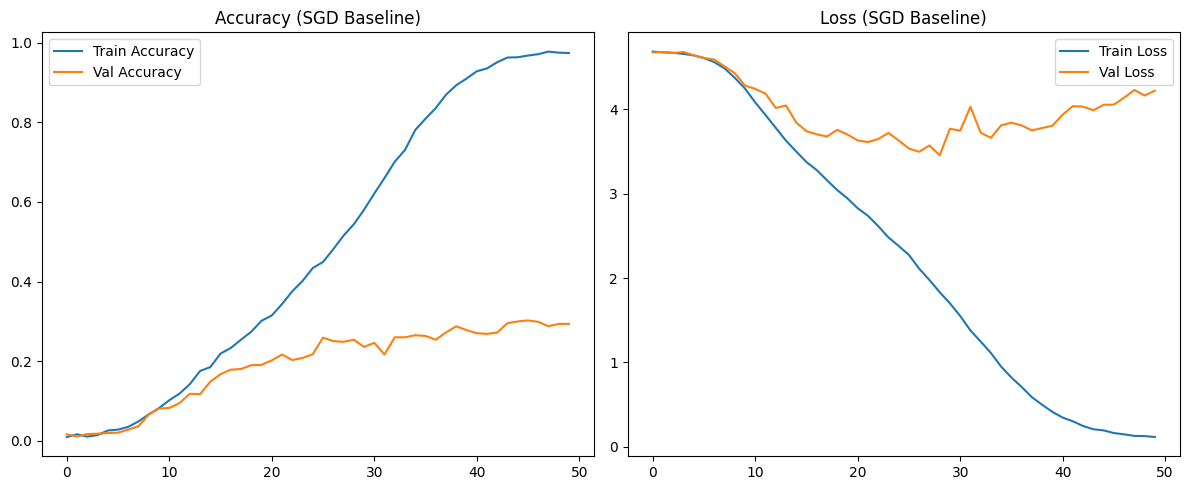

In [20]:
def plot_metrics(history, title_suffix=""):
    plt.figure(figsize=(12, 5))
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'Accuracy {title_suffix}')
    plt.legend()
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Loss {title_suffix}')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_metrics(history_sgd, "(SGD Baseline)")

22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step
Accuracy: 0.3173
F1 Score: 0.3088
                               precision    recall  f1-score   support

         adho mukha svanasana       0.11      0.12      0.12         8
        adho mukha vriksasana       0.25      0.14      0.18         7
              agnistambhasana       0.25      0.25      0.25         4
              ananda balasana       0.29      0.29      0.29         7
                   anantasana       0.44      0.80      0.57         5
                 anjaneyasana       0.20      0.38      0.26         8
              ardha bhekasana       0.00      0.00      0.00         4
            ardha chandrasana       0.09      0.50      0.15         6
         ardha matsyendrasana       0.25      0.10      0.14        10
      ardha pincha mayurasana       0.29      0.33      0.31         6
             ardha uttanasana       0.38      0.43      0.40         7
           ashtanga namaskara       0.50      0.20      0.29         5
 

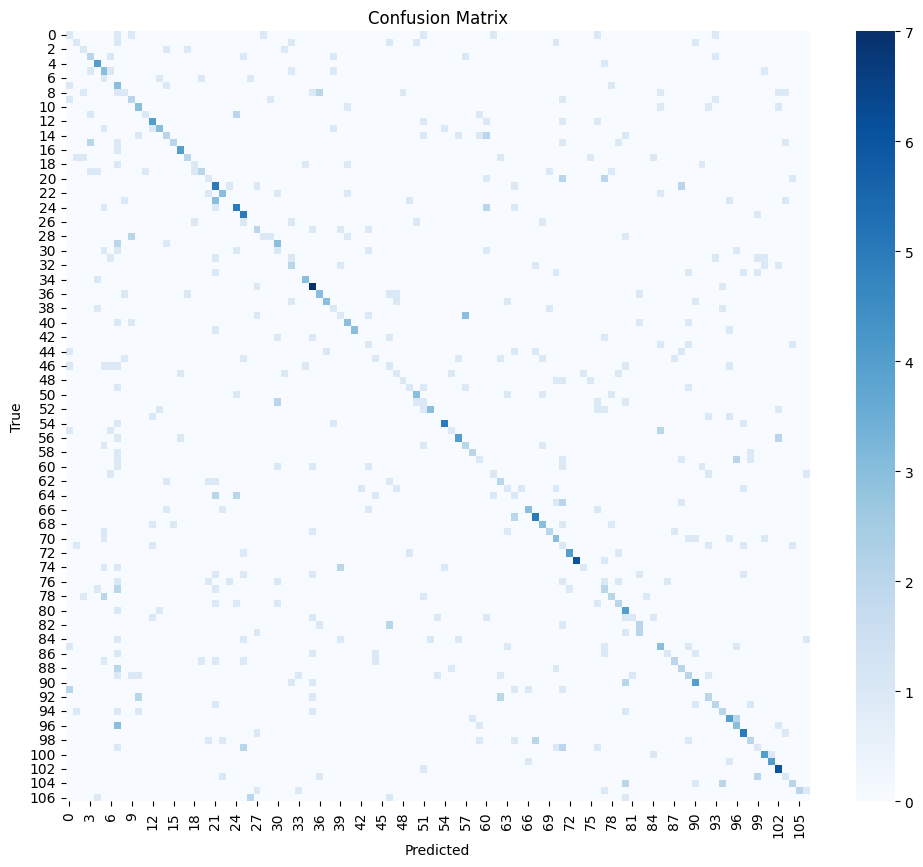

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
def evaluate_model(model, test_gen):
    y_pred_probs = model.predict(test_gen)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_gen.classes

    acc = np.mean(y_pred == y_true)
    f1 = f1_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return acc, f1

acc_basic, f1_basic = evaluate_model(model, test_gen)

In [22]:
from tensorflow.keras.callbacks import TensorBoard
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

callbacks = [
    tensorboard,
    early_stop,
    lr_schedule
]


Epoch 1/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 27s 193ms/step - accuracy: 0.0120 - loss: 4.6994 - val_accuracy: 0.0441 - val_loss: 4.6068 - learning_rate: 0.0100
Epoch 2/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 177ms/step - accuracy: 0.0888 - loss: 4.3774 - val_accuracy: 0.1962 - val_loss: 3.8562 - learning_rate: 0.0100
Epoch 3/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 176ms/step - accuracy: 0.4275 - loss: 2.5957 - val_accuracy: 0.2550 - val_loss: 3.5413 - learning_rate: 0.0100
Epoch 4/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 177ms/step - accuracy: 0.8652 - loss: 0.6533 - val_accuracy: 0.2748 - val_loss: 3.8839 - learning_rate: 0.0100
Epoch 5/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 176ms/step - accuracy: 0.9702 - loss: 0.2271 - val_accuracy: 0.2766 - val_loss: 4.1508 - learning_rate: 0.0100
Epoch 6/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9734 - loss: 0.2040
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 176ms/step - accuracy: 0.9734

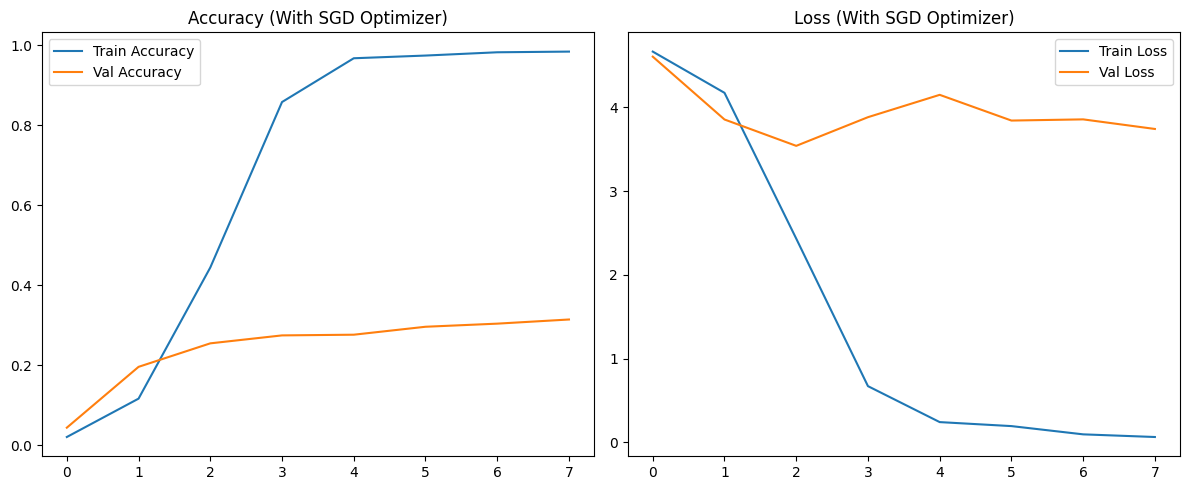

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step
Accuracy: 0.2635
F1 Score: 0.2368
                               precision    recall  f1-score   support

         adho mukha svanasana       0.22      0.25      0.24         8
        adho mukha vriksasana       0.20      0.43      0.27         7
              agnistambhasana       0.14      0.25      0.18         4
              ananda balasana       0.50      0.14      0.22         7
                   anantasana       1.00      0.20      0.33         5
                 anjaneyasana       0.45      0.62      0.53         8
              ardha bhekasana       0.00      0.00      0.00         4
            ardha chandrasana       0.00      0.00      0.00         6
         ardha matsyendrasana       0.50      0.20      0.29        10
      ardha pincha mayurasana       0.27      0.50      0.35         6
             ardha uttanasana       0.14      0.29      0.19         7
           ashtanga namaskara       0.00      0.00      0.00         5
 

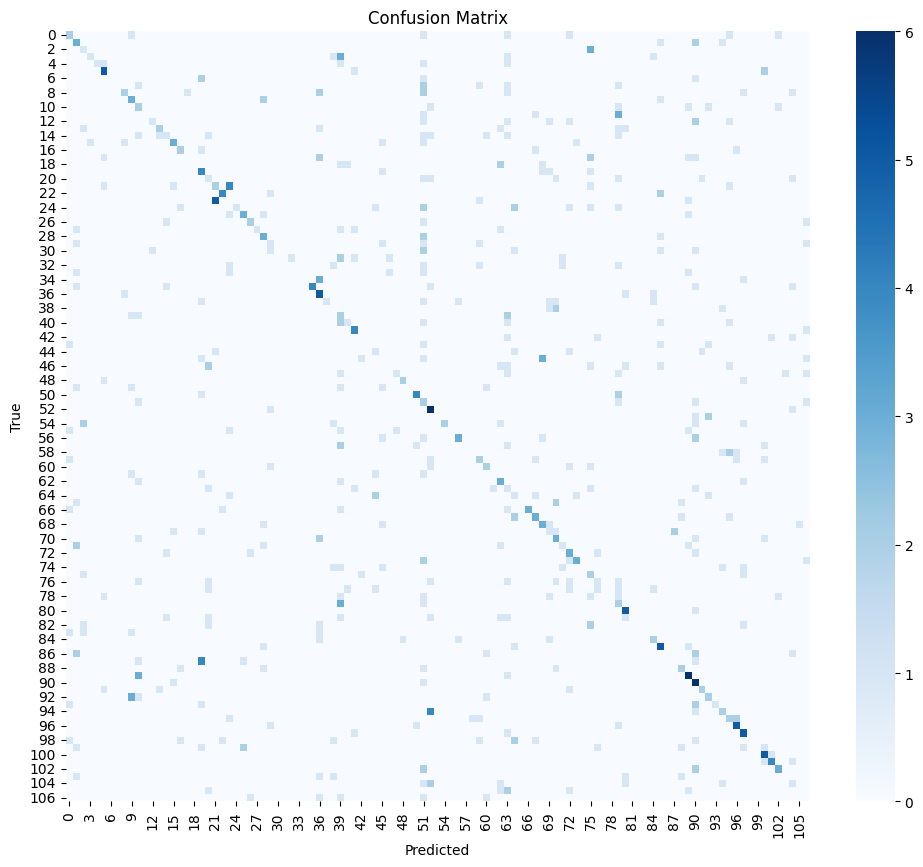

In [24]:
# Apply call backs, including Early Stopping and Learning Rate Scheduling
# Adjust optimizer and learning rate
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

optimizers = {
    'SGD': SGD(learning_rate=0.01, momentum=0.9),
    'Adam': Adam(learning_rate=0.0003),
    'RMSprop': RMSprop(learning_rate=0.0003)
}

model_improved = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(train_gen.num_classes, activation='softmax')
])

# Compile the model with SGD optimizer
model_improved.compile(optimizer=optimizers['SGD'], loss='categorical_crossentropy', metrics=['accuracy'])

history_improved = model_improved.fit(
    train_gen,
    validation_data=val_gen,
    epochs=70,
    callbacks= callbacks,
)

plot_metrics(history_improved, "(With SGD Optimizer)")
acc_sgd, f1_sgd = evaluate_model(model_improved, test_gen)

Epoch 1/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 28s 197ms/step - accuracy: 0.8588 - loss: 0.7600 - val_accuracy: 0.2982 - val_loss: 3.6167 - learning_rate: 3.0000e-04
Epoch 2/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 176ms/step - accuracy: 0.9771 - loss: 0.2089 - val_accuracy: 0.2999 - val_loss: 3.8373 - learning_rate: 3.0000e-04
Epoch 3/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 177ms/step - accuracy: 0.9790 - loss: 0.2022 - val_accuracy: 0.3094 - val_loss: 3.8112 - learning_rate: 3.0000e-04
Epoch 4/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9784 - loss: 0.2073
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 177ms/step - accuracy: 0.9784 - loss: 0.2074 - val_accuracy: 0.2869 - val_loss: 3.9525 - learning_rate: 3.0000e-04
Epoch 5/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 177ms/step - accuracy: 0.9807 - loss: 0.1481 - val_accuracy: 0.3207 - val_loss: 3.7227 - learning_rate: 1.5000e-04
Epoch 6/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 176ms/st

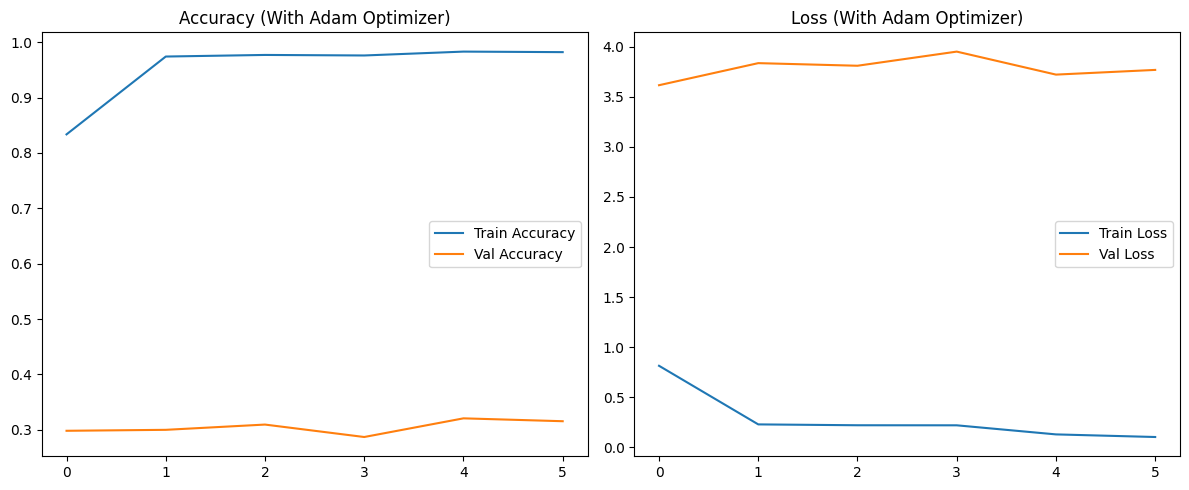

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step
Accuracy: 0.2897
F1 Score: 0.2842
                               precision    recall  f1-score   support

         adho mukha svanasana       0.25      0.25      0.25         8
        adho mukha vriksasana       0.50      0.14      0.22         7
              agnistambhasana       0.33      0.25      0.29         4
              ananda balasana       0.20      0.29      0.24         7
                   anantasana       1.00      0.20      0.33         5
                 anjaneyasana       0.17      0.38      0.23         8
              ardha bhekasana       0.11      0.25      0.15         4
            ardha chandrasana       0.40      0.33      0.36         6
         ardha matsyendrasana       0.50      0.20      0.29        10
      ardha pincha mayurasana       0.38      0.50      0.43         6
             ardha uttanasana       0.23      0.43      0.30         7
           ashtanga namaskara       0.50      0.20      0.29         5
 

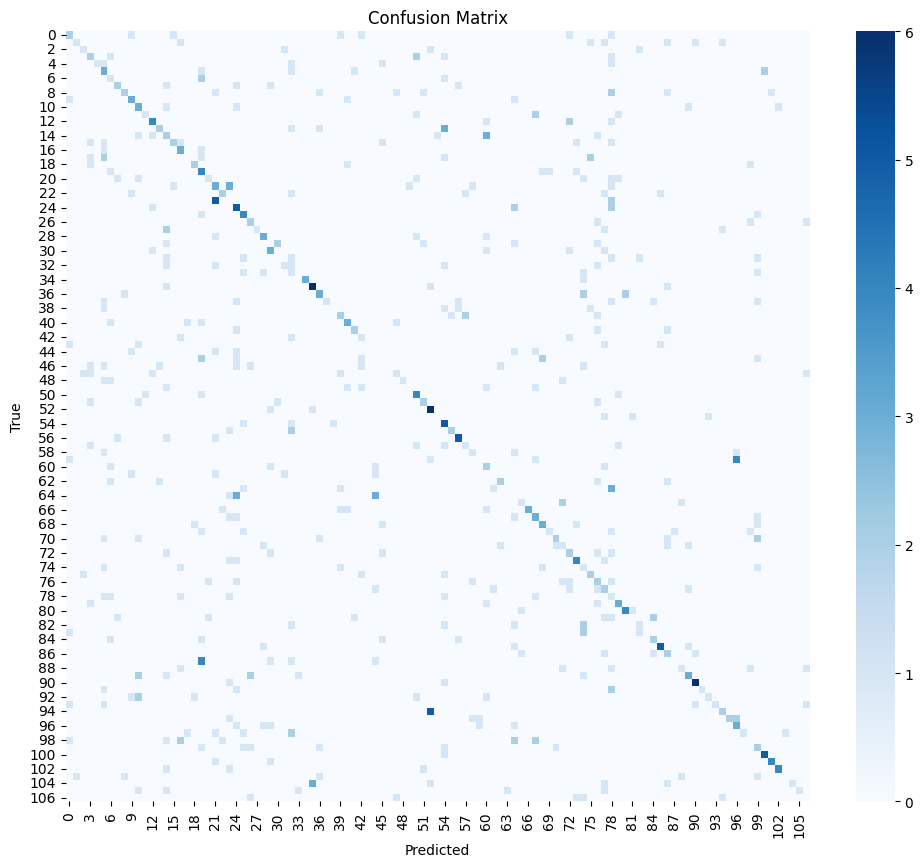

In [25]:
# Compile the model with Adam optimizer
model_improved.compile(optimizer=optimizers['Adam'], loss='categorical_crossentropy', metrics=['accuracy'])

history_Adam = model_improved.fit(
    train_gen,
    validation_data=val_gen,
    epochs=70,
    callbacks= callbacks,
)

plot_metrics(history_Adam, "(With Adam Optimizer)")
acc_adam, f1_adam = evaluate_model(model_improved, test_gen)

Epoch 1/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 190ms/step - accuracy: 0.9610 - loss: 0.3125 - val_accuracy: 0.3163 - val_loss: 3.8188 - learning_rate: 3.0000e-04
Epoch 2/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 178ms/step - accuracy: 0.9812 - loss: 0.1556 - val_accuracy: 0.3008 - val_loss: 3.7548 - learning_rate: 3.0000e-04
Epoch 3/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 176ms/step - accuracy: 0.9844 - loss: 0.1110 - val_accuracy: 0.2887 - val_loss: 4.1278 - learning_rate: 3.0000e-04
Epoch 4/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 177ms/step - accuracy: 0.9817 - loss: 0.1328 - val_accuracy: 0.3111 - val_loss: 3.8734 - learning_rate: 3.0000e-04
Epoch 5/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9818 - loss: 0.1321
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 175ms/step - accuracy: 0.9817 - loss: 0.1323 - val_accuracy: 0.3077 - val_loss: 3.8574 - learning_rate: 3.0000e-04
Epoch 6/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 176ms/st

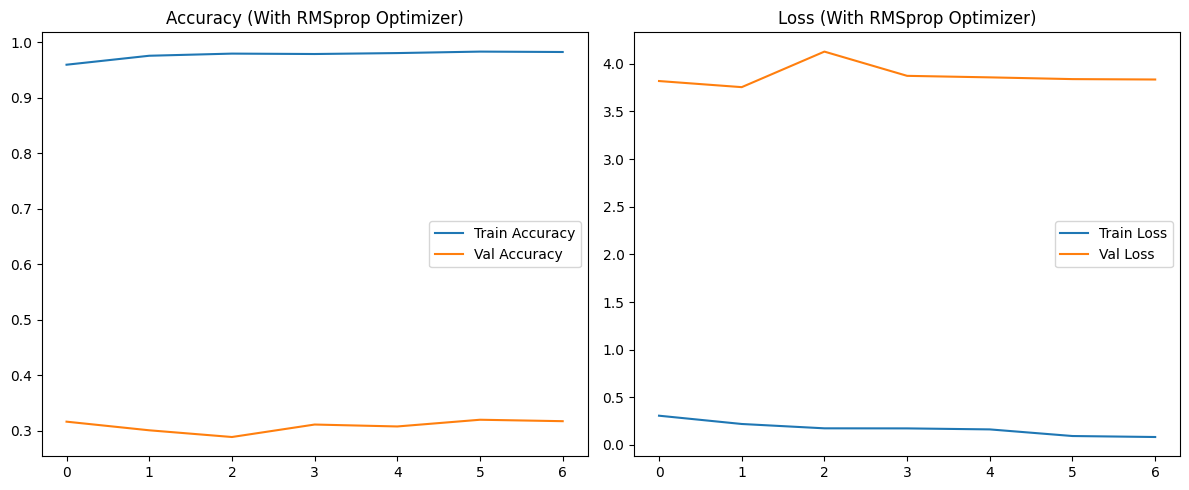

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step
Accuracy: 0.3086
F1 Score: 0.2982
                               precision    recall  f1-score   support

         adho mukha svanasana       0.17      0.25      0.20         8
        adho mukha vriksasana       0.18      0.29      0.22         7
              agnistambhasana       0.12      0.25      0.17         4
              ananda balasana       0.20      0.14      0.17         7
                   anantasana       0.36      0.80      0.50         5
                 anjaneyasana       0.18      0.62      0.28         8
              ardha bhekasana       0.17      0.25      0.20         4
            ardha chandrasana       0.67      0.33      0.44         6
         ardha matsyendrasana       0.33      0.10      0.15        10
      ardha pincha mayurasana       0.50      0.50      0.50         6
             ardha uttanasana       0.43      0.43      0.43         7
           ashtanga namaskara       0.50      0.20      0.29         5
 

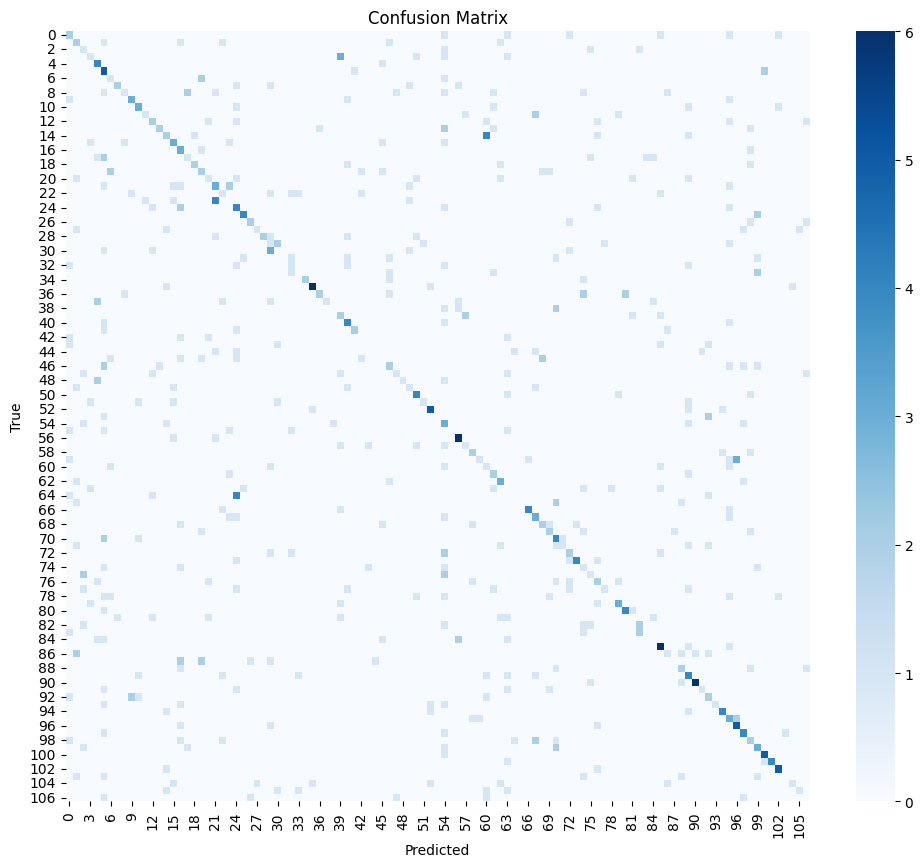

In [26]:
# try Rmsprop optimizer
model_improved.compile(optimizer=optimizers['RMSprop'], loss='categorical_crossentropy', metrics=['accuracy'])

history_rmsprop = model_improved.fit(
    train_gen,
    validation_data=val_gen,
    epochs=70,
    callbacks= callbacks,
)

plot_metrics(history_rmsprop, "(With RMSprop Optimizer)")
acc_rms, f1_rms = evaluate_model(model_improved, test_gen)

Epoch 1/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 27s 191ms/step - accuracy: 0.9844 - loss: 0.0892 - val_accuracy: 0.3094 - val_loss: 3.8830 - learning_rate: 1.0000e-04
Epoch 2/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 177ms/step - accuracy: 0.9869 - loss: 0.0703 - val_accuracy: 0.3215 - val_loss: 3.8501 - learning_rate: 1.0000e-04
Epoch 3/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 177ms/step - accuracy: 0.9873 - loss: 0.0936 - val_accuracy: 0.3129 - val_loss: 3.7913 - learning_rate: 1.0000e-04
Epoch 4/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 176ms/step - accuracy: 0.9838 - loss: 0.0909 - val_accuracy: 0.3068 - val_loss: 3.9057 - learning_rate: 1.0000e-04
Epoch 5/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 176ms/step - accuracy: 0.9879 - loss: 0.0715 - val_accuracy: 0.3207 - val_loss: 3.7658 - learning_rate: 1.0000e-04
Epoch 6/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 177ms/step - accuracy: 0.9872 - loss: 0.0660 - val_accuracy: 0.3086 - val_loss: 3.8818 - learning_rate: 1.0000e-04
Epoch 7/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 17

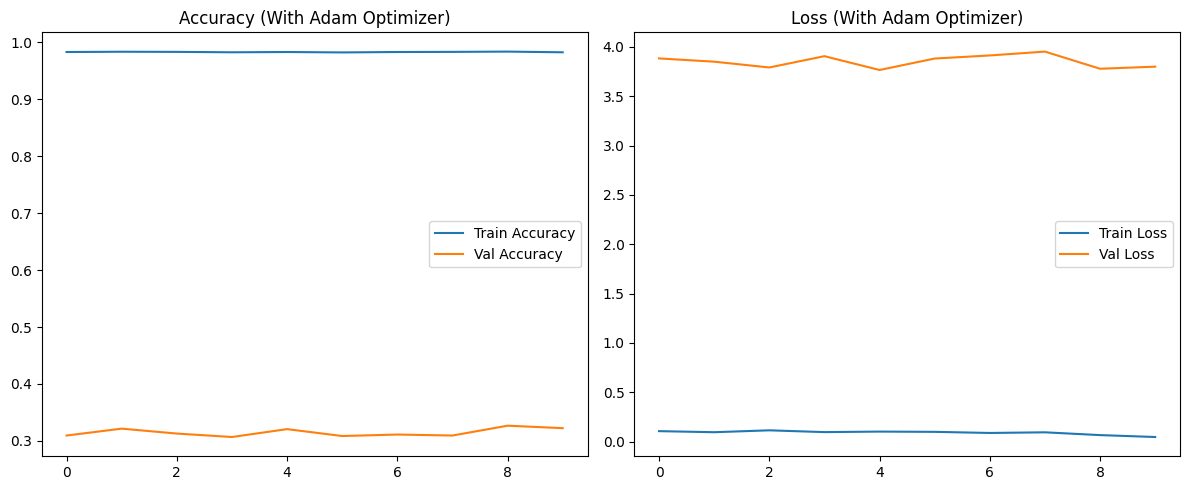

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step
Accuracy: 0.3319
F1 Score: 0.3221
                               precision    recall  f1-score   support

         adho mukha svanasana       0.22      0.25      0.24         8
        adho mukha vriksasana       0.20      0.14      0.17         7
              agnistambhasana       0.20      0.25      0.22         4
              ananda balasana       0.43      0.43      0.43         7
                   anantasana       0.43      0.60      0.50         5
                 anjaneyasana       0.36      0.62      0.45         8
              ardha bhekasana       0.33      0.25      0.29         4
            ardha chandrasana       0.50      0.33      0.40         6
         ardha matsyendrasana       0.15      0.20      0.17        10
      ardha pincha mayurasana       0.40      0.33      0.36         6
             ardha uttanasana       0.20      0.29      0.24         7
           ashtanga namaskara       1.00      0.20      0.33         5
 

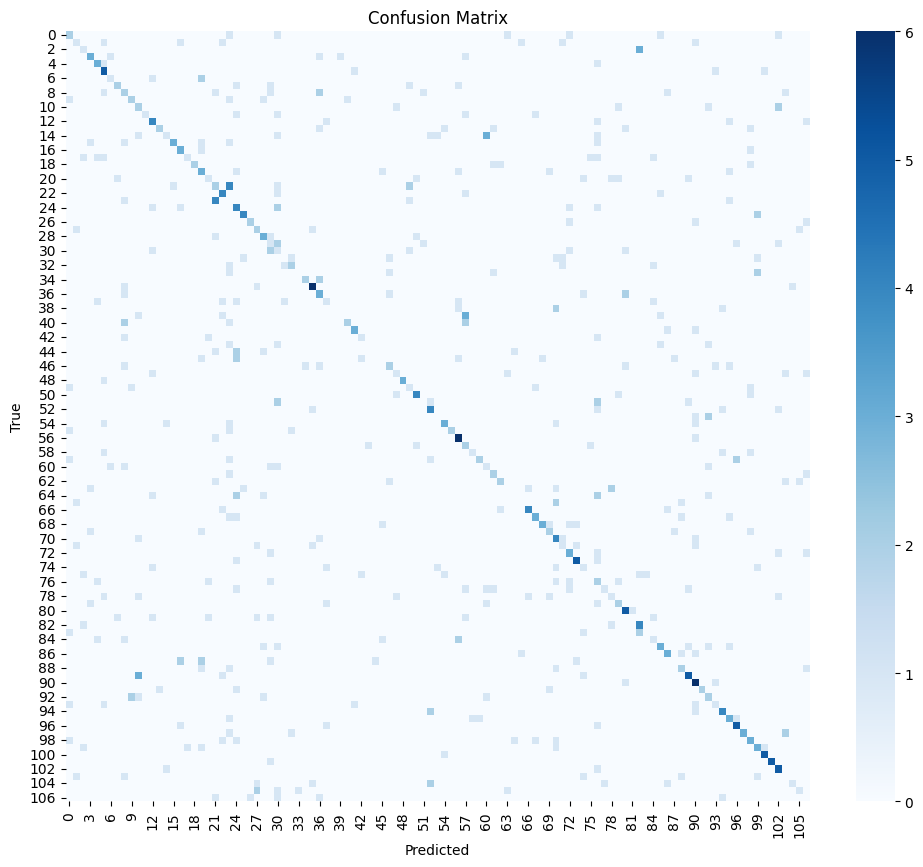

In [29]:
# try adam optimizer with a different learning rate

model_improved.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history_adam1 = model_improved.fit(
    train_gen,
    validation_data=val_gen,
    epochs=70,
    callbacks= callbacks,
)

plot_metrics(history_adam1, "(With Adam Optimizer)")
acc_adam1, f1_adam1 = evaluate_model(model_improved, test_gen)

In [30]:
basic_results = [
    {'Model': 'Basic Model', 'Accuracy': round(acc_basic, 4), 'F1 Score': round(f1_basic, 4)},
    {'Model': 'SGD with Momentum', 'Accuracy': round(acc_sgd, 4), 'F1 Score': round(f1_sgd, 4)},
    {'Model': 'ADAM with 0.0003 Learning Rate', 'Accuracy': round(acc_adam, 4), 'F1 Score': round(f1_adam, 4)},
    {'Model': 'RMSrops', 'Accuracy': round(acc_rms, 4), 'F1 Score': round(f1_rms, 4)},
    {'Model': 'ADAM with 0.0001 Learning Rate', 'Accuracy': round(acc_adam1, 4), 'F1 Score': round(f1_adam1, 4)}
]

# Convert to DataFrame
df_basicresults = pd.DataFrame(basic_results)
display(df_basicresults)

,Model,Accuracy,F1 Score
0,Basic Model,0.3173,0.3088
1,SGD with Momentum,0.2635,0.2368
2,ADAM with 0.0003 Learning Rate,0.2897,0.2842
3,RMSrops,0.3086,0.2982
4,ADAM with 0.0001 Learning Rate,0.3319,0.3221


Optimizer Adam with 0.0001 learning rate has the highest accuracy which is chosen for further improvement.

In [31]:
# Find classes with 0 precision
y_pred_probs = model_improved.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes

report = classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys(), output_dict=True)
zero_precision_classes = [cls for cls, metrics in report.items() if isinstance(metrics, dict) and metrics['precision'] == 0.0]

print("Classes with 0 precision:")
for cls in zero_precision_classes:
    print(cls)

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step
Classes with 0 precision:
chakravakasana
eka pada rajakapotasana
ganda bherundasana
hanumanasana
janu sirsasana
lolasana
makara adho mukha svanasana
makarasana
mayurasana
padangusthasana
paschimottanasana
phalakasana
pincha mayurasana
sukhasana
tittibhasana
tulasana
urdhva mukha svanasana
virasana
yoganidrasana


The classes above are poses that the model struggled most with.

Epoch 1/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 46s 266ms/step - accuracy: 0.0087 - loss: 4.6704 - val_accuracy: 0.0147 - val_loss: 4.6469 - learning_rate: 1.0000e-04
Epoch 2/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 179ms/step - accuracy: 0.0141 - loss: 4.6484 - val_accuracy: 0.0303 - val_loss: 4.5446 - learning_rate: 1.0000e-04
Epoch 3/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 176ms/step - accuracy: 0.0655 - loss: 4.3275 - val_accuracy: 0.1737 - val_loss: 3.6854 - learning_rate: 1.0000e-04
Epoch 4/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 176ms/step - accuracy: 0.2665 - loss: 3.1784 - val_accuracy: 0.3034 - val_loss: 3.2108 - learning_rate: 1.0000e-04
Epoch 5/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 177ms/step - accuracy: 0.4171 - loss: 2.4051 - val_accuracy: 0.3621 - val_loss: 2.9102 - learning_rate: 1.0000e-04
Epoch 6/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 176ms/step - accuracy: 0.5552 - loss: 1.7458 - val_accuracy: 0.3924 - val_loss: 2.9187 - learning_rate: 1.0000e-04
Epoch 7/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 17

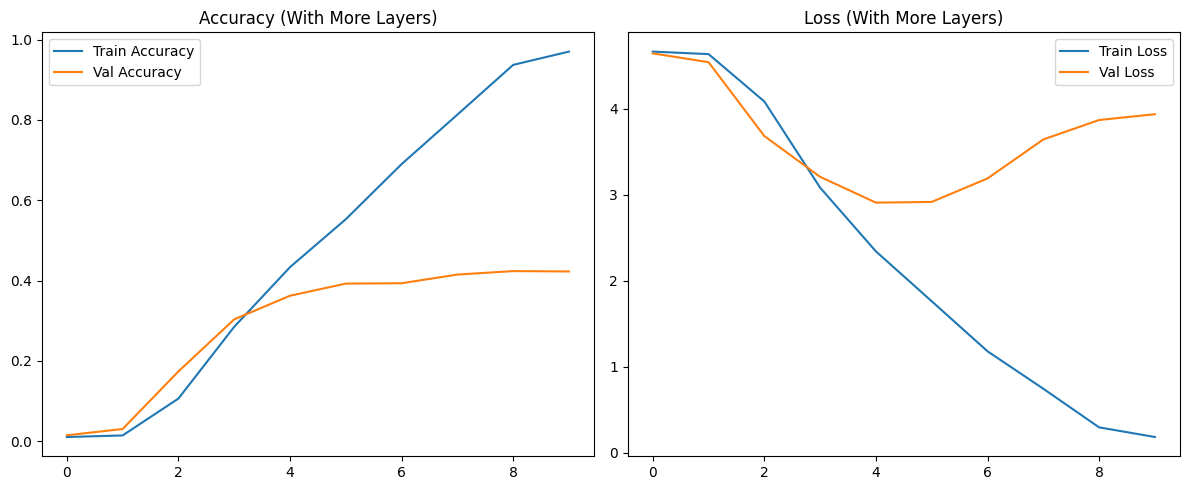

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step
Accuracy: 0.3595
F1 Score: 0.3300
                               precision    recall  f1-score   support

         adho mukha svanasana       0.38      0.38      0.38         8
        adho mukha vriksasana       0.33      0.14      0.20         7
              agnistambhasana       0.00      0.00      0.00         4
              ananda balasana       0.33      0.71      0.45         7
                   anantasana       0.67      0.80      0.73         5
                 anjaneyasana       0.40      0.25      0.31         8
              ardha bhekasana       0.00      0.00      0.00         4
            ardha chandrasana       0.40      0.33      0.36         6
         ardha matsyendrasana       0.67      0.20      0.31        10
      ardha pincha mayurasana       0.50      0.67      0.57         6
             ardha uttanasana       0.43      0.43      0.43         7
           ashtanga namaskara       1.00      0.40      0.57         5
 

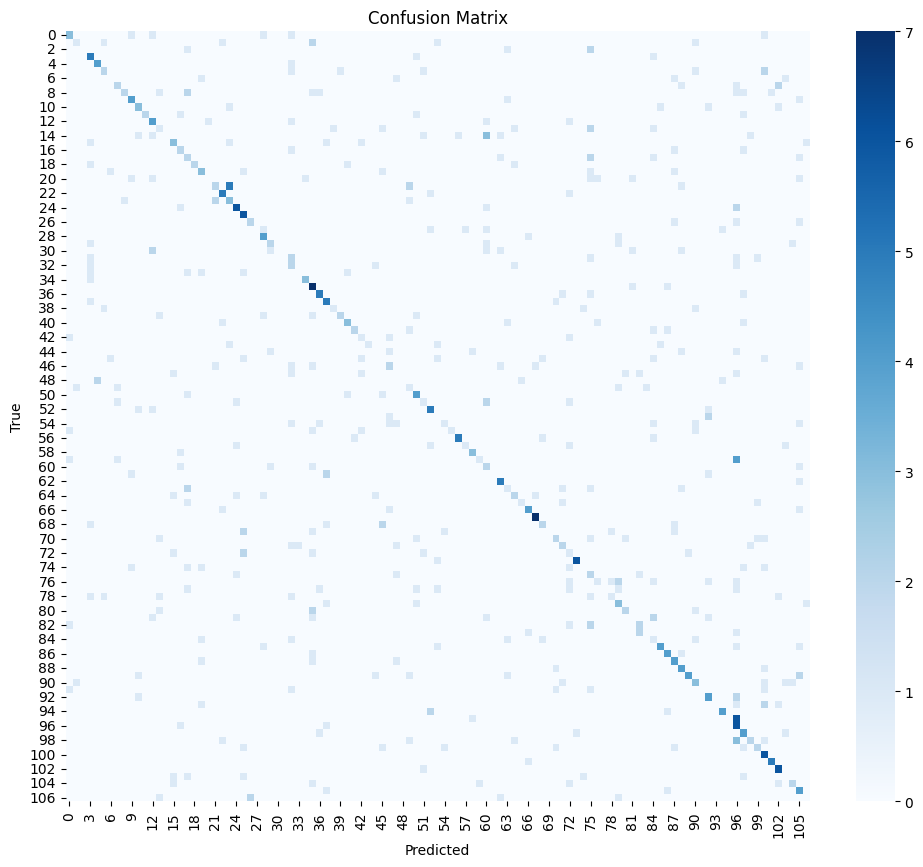

In [33]:
# add more layers
model_morelayer = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding = 'same', input_shape=(128, 128, 3)),
    Conv2D(32, (3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu', padding = 'same'),
    Conv2D(64, (3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu', padding = 'same'),
    Conv2D(128, (3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu', padding = 'same'),
    Conv2D(256, (3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(2, 2),

    Conv2D(512, (3, 3), activation='relu', padding = 'same'),
    Conv2D(512, (3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(train_gen.num_classes, activation='softmax')
])
model_morelayer.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history_morelayer = model_morelayer.fit(
    train_gen,
    validation_data=val_gen,
    epochs=70,
    callbacks= callbacks
)
plot_metrics(history_morelayer, "(With More Layers)")
acc_morelayer, f1_morelayer = evaluate_model(model_morelayer, test_gen)

Epoch 1/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 47s 269ms/step - accuracy: 0.0134 - loss: 4.6702 - val_accuracy: 0.0156 - val_loss: 4.6610 - learning_rate: 1.0000e-04
Epoch 2/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 180ms/step - accuracy: 0.0241 - loss: 4.6306 - val_accuracy: 0.0717 - val_loss: 4.2826 - learning_rate: 1.0000e-04
Epoch 3/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 180ms/step - accuracy: 0.1318 - loss: 3.8902 - val_accuracy: 0.2247 - val_loss: 3.4310 - learning_rate: 1.0000e-04
Epoch 4/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 180ms/step - accuracy: 0.3310 - loss: 2.7660 - val_accuracy: 0.3449 - val_loss: 2.8714 - learning_rate: 1.0000e-04
Epoch 5/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 180ms/step - accuracy: 0.5242 - loss: 1.8883 - val_accuracy: 0.4019 - val_loss: 2.8384 - learning_rate: 1.0000e-04
Epoch 6/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 179ms/step - accuracy: 0.7041 - loss: 1.1631 - val_accuracy: 0.4313 - val_loss: 2.7589 - learning_rate: 1.0000e-04
Epoch 7/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 17

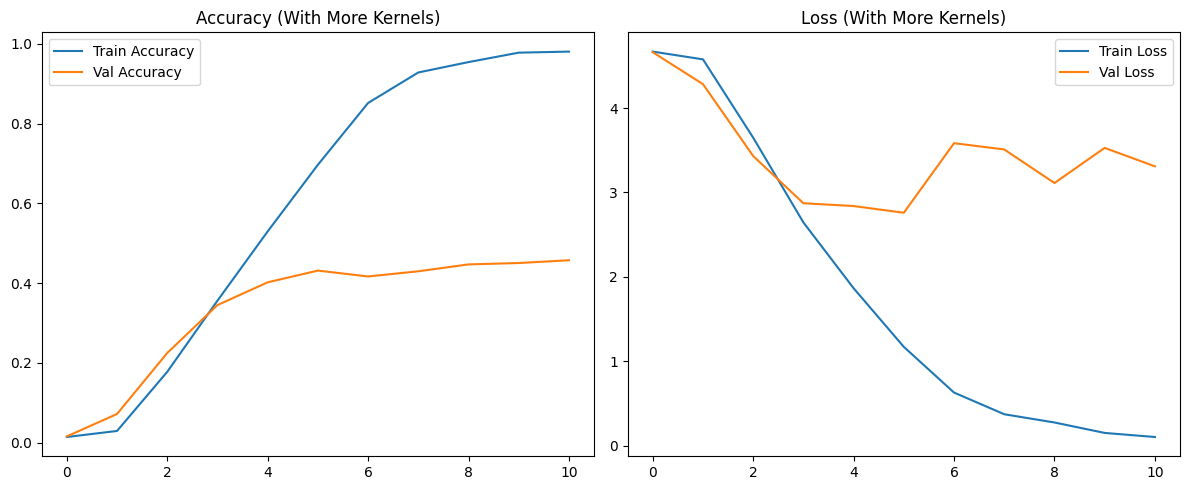

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 255ms/step
Accuracy: 0.4207
F1 Score: 0.4090
                               precision    recall  f1-score   support

         adho mukha svanasana       0.60      0.38      0.46         8
        adho mukha vriksasana       0.50      0.29      0.36         7
              agnistambhasana       0.00      0.00      0.00         4
              ananda balasana       0.27      0.43      0.33         7
                   anantasana       0.80      0.80      0.80         5
                 anjaneyasana       0.62      0.62      0.62         8
              ardha bhekasana       0.50      0.25      0.33         4
            ardha chandrasana       0.50      0.50      0.50         6
         ardha matsyendrasana       0.60      0.60      0.60        10
      ardha pincha mayurasana       0.60      0.50      0.55         6
             ardha uttanasana       0.60      0.43      0.50         7
           ashtanga namaskara       0.67      0.40      0.50         5
 

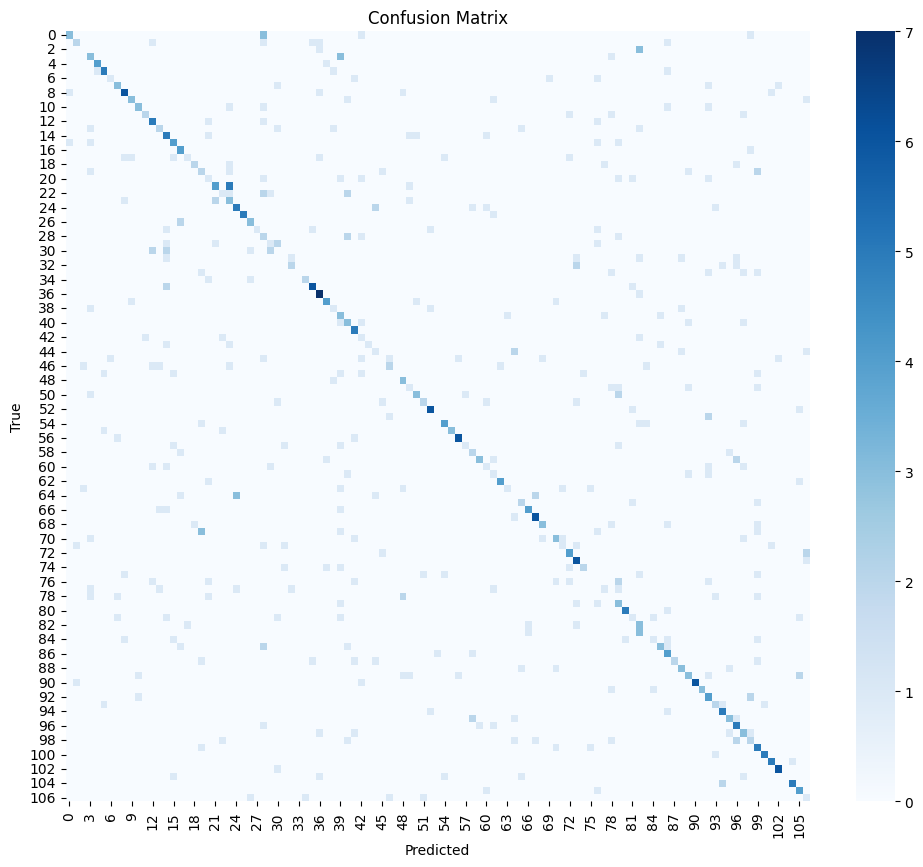

In [34]:
# Increase the number of kernels
model_more_kernels = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=(128, 128, 3)),
    Conv2D(64, (3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu', padding = 'same'),
    Conv2D(128, (3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu', padding = 'same'),
    Conv2D(256, (3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(2, 2),

    Conv2D(512, (3, 3), activation='relu', padding = 'same'),
    Conv2D(512, (3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(2, 2),

    Conv2D(512, (3, 3), activation='relu', padding = 'same'),
    Conv2D(512, (3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(1024, activation='relu'),
    Dense(train_gen.num_classes, activation='softmax')
])

model_more_kernels.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history_more_kernels = model_more_kernels.fit(
    train_gen,
    validation_data=val_gen,
    epochs=70,
    callbacks= callbacks
)
plot_metrics(history_more_kernels, "(With More Kernels)")
acc_morekernel, f1_morekernel = evaluate_model(model_more_kernels, test_gen)

Epoch 1/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 42s 231ms/step - accuracy: 0.0574 - loss: 5.0284 - val_accuracy: 0.0112 - val_loss: 5.2314 - learning_rate: 1.0000e-04
Epoch 2/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 24s 181ms/step - accuracy: 0.4115 - loss: 2.5403 - val_accuracy: 0.0104 - val_loss: 6.2344 - learning_rate: 1.0000e-04
Epoch 3/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 24s 185ms/step - accuracy: 0.7085 - loss: 1.2229 - val_accuracy: 0.0432 - val_loss: 5.0203 - learning_rate: 1.0000e-04
Epoch 4/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 24s 186ms/step - accuracy: 0.9057 - loss: 0.4740 - val_accuracy: 0.2221 - val_loss: 3.5352 - learning_rate: 1.0000e-04
Epoch 5/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 24s 181ms/step - accuracy: 0.9622 - loss: 0.2951 - val_accuracy: 0.3362 - val_loss: 3.0492 - learning_rate: 1.0000e-04
Epoch 6/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 24s 182ms/step - accuracy: 0.9698 - loss: 0.2280 - val_accuracy: 0.3647 - val_loss: 2.9741 - learning_rate: 1.0000e-04
Epoch 7/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 24s 18

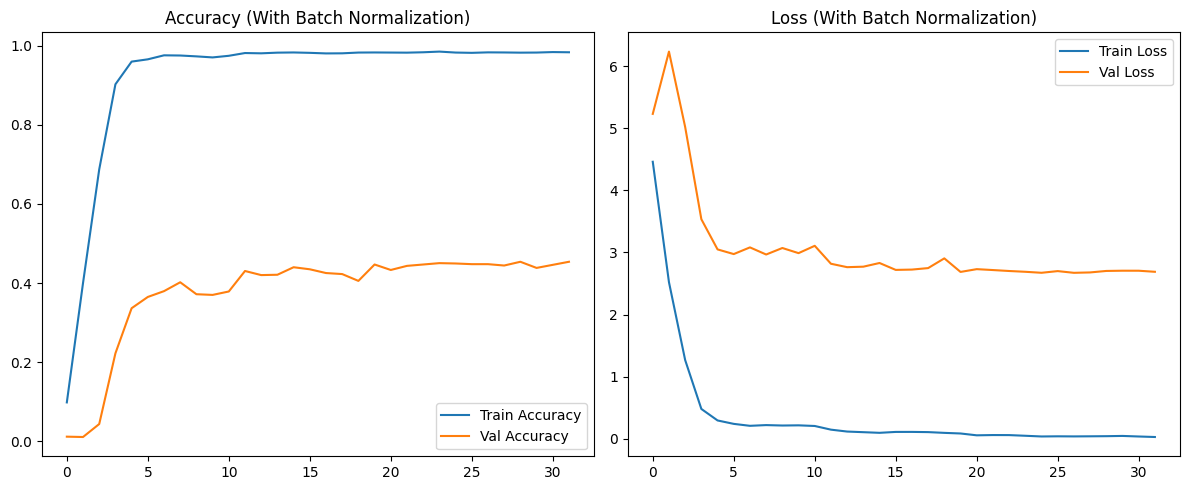

22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step
Accuracy: 0.4410
F1 Score: 0.4274
                               precision    recall  f1-score   support

         adho mukha svanasana       0.40      0.50      0.44         8
        adho mukha vriksasana       0.17      0.14      0.15         7
              agnistambhasana       0.25      0.25      0.25         4
              ananda balasana       0.57      0.57      0.57         7
                   anantasana       0.57      0.80      0.67         5
                 anjaneyasana       0.33      0.38      0.35         8
              ardha bhekasana       0.25      0.25      0.25         4
            ardha chandrasana       0.33      0.33      0.33         6
         ardha matsyendrasana       0.31      0.40      0.35        10
      ardha pincha mayurasana       0.50      0.50      0.50         6
             ardha uttanasana       0.38      0.43      0.40         7
           ashtanga namaskara       0.50      0.40      0.44         5
 

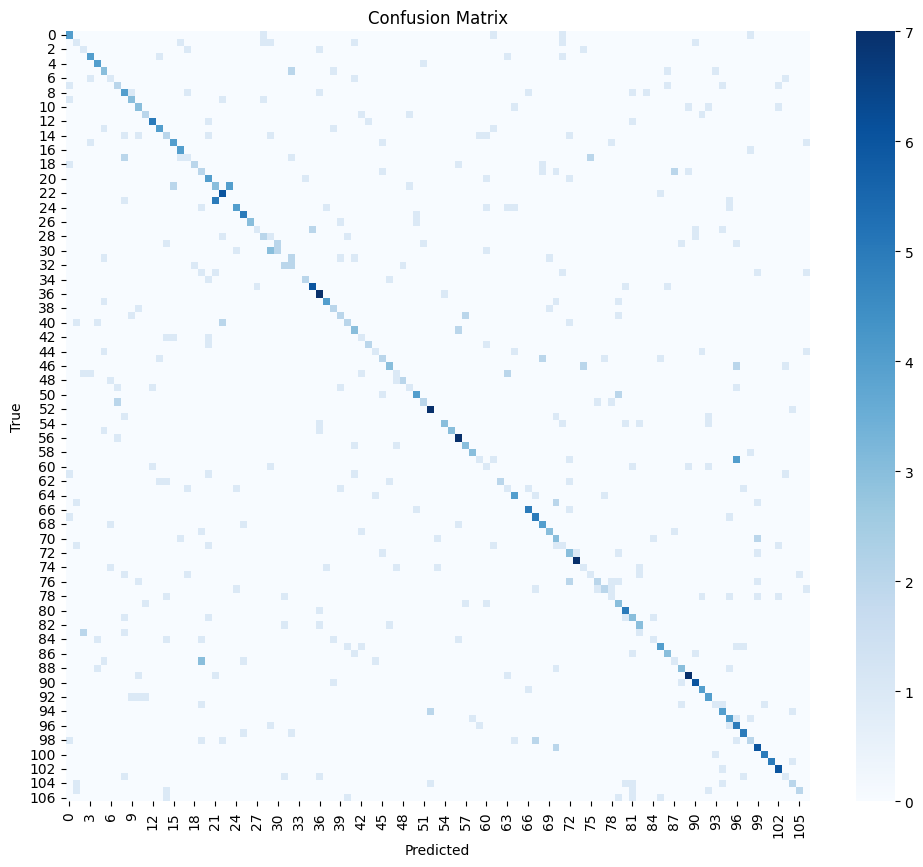

In [35]:
# Add Batch Normalization
model_bn = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(1024, activation='relu'),
    Dense(train_gen.num_classes, activation='softmax')
])
model_bn.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history_bn = model_bn.fit(
    train_gen,
    validation_data=val_gen,
    epochs=70,
    callbacks= callbacks
)
plot_metrics(history_bn, "(With Batch Normalization)")
acc_bn, f1_bn = evaluate_model(model_bn, test_gen)

Epoch 1/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 37s 226ms/step - accuracy: 0.0123 - loss: 36.7896 - val_accuracy: 0.0156 - val_loss: 14.4146 - learning_rate: 1.0000e-04
Epoch 2/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 179ms/step - accuracy: 0.0169 - loss: 11.6205 - val_accuracy: 0.0156 - val_loss: 6.7106 - learning_rate: 1.0000e-04
Epoch 3/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 179ms/step - accuracy: 0.0167 - loss: 6.1491 - val_accuracy: 0.0147 - val_loss: 5.1629 - learning_rate: 1.0000e-04
Epoch 4/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 179ms/step - accuracy: 0.0104 - loss: 5.0537 - val_accuracy: 0.0156 - val_loss: 4.8189 - learning_rate: 1.0000e-04
Epoch 5/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 179ms/step - accuracy: 0.0124 - loss: 4.7893 - val_accuracy: 0.0156 - val_loss: 4.7126 - learning_rate: 1.0000e-04
Epoch 6/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 179ms/step - accuracy: 0.0184 - loss: 4.7074 - val_accuracy: 0.0147 - val_loss: 4.6736 - learning_rate: 1.0000e-04
Epoch 7/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s

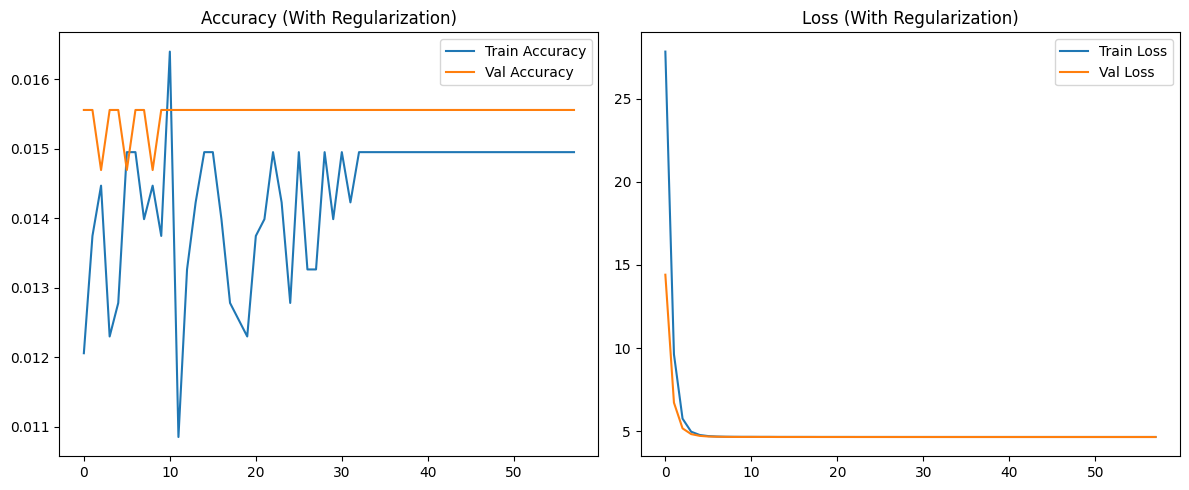

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step
Accuracy: 0.0146
F1 Score: 0.0004
                               precision    recall  f1-score   support

         adho mukha svanasana       0.00      0.00      0.00         8
        adho mukha vriksasana       0.00      0.00      0.00         7
              agnistambhasana       0.00      0.00      0.00         4
              ananda balasana       0.00      0.00      0.00         7
                   anantasana       0.00      0.00      0.00         5
                 anjaneyasana       0.00      0.00      0.00         8
              ardha bhekasana       0.00      0.00      0.00         4
            ardha chandrasana       0.00      0.00      0.00         6
         ardha matsyendrasana       0.00      0.00      0.00        10
      ardha pincha mayurasana       0.00      0.00      0.00         6
             ardha uttanasana       0.00      0.00      0.00         7
           ashtanga namaskara       0.00      0.00      0.00         5
 

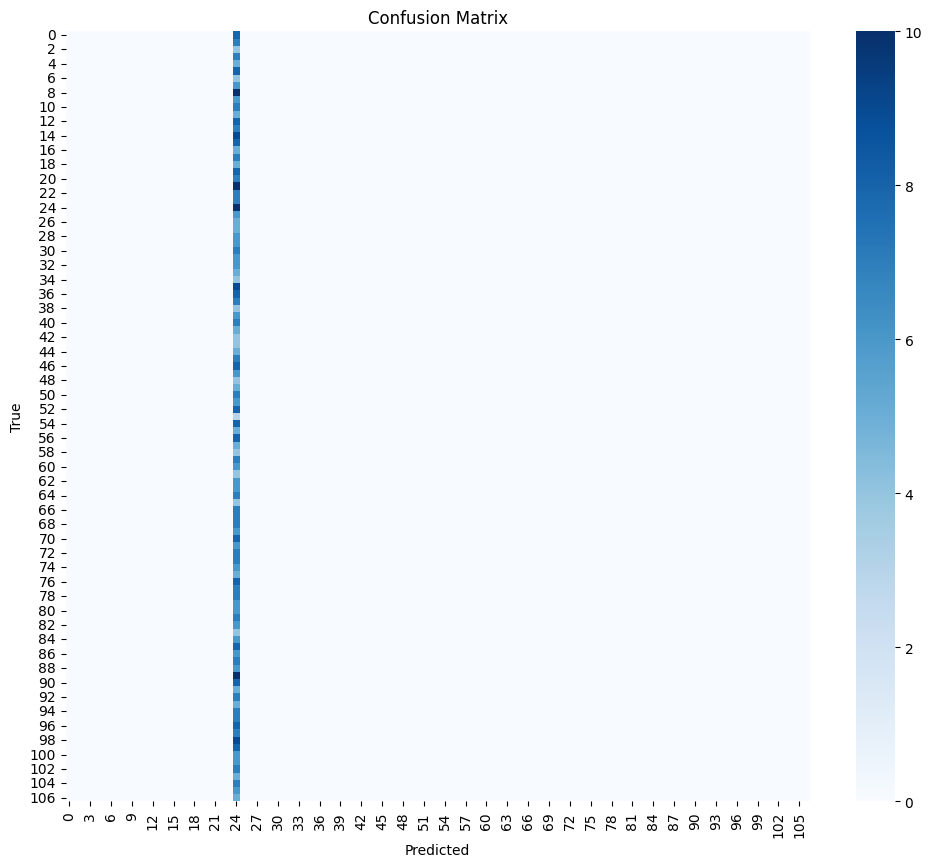

In [36]:
# Add Regularization
model_reg = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same',
           input_shape=(128, 128, 3), kernel_regularizer=regularizers.l2(0.01)),
    Conv2D(64, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.01)),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.01)),
    Conv2D(128, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.01)),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.01)),
    Conv2D(256, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.01)),
    MaxPooling2D(2, 2),

    Conv2D(512, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.01)),
    Conv2D(512, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.01)),
    MaxPooling2D(2, 2),

    Conv2D(512, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.01)),
    Conv2D(512, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.01)),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(train_gen.num_classes, activation='softmax')
])

model_reg.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history_reg = model_reg.fit(
    train_gen,
    validation_data=val_gen,
    epochs=70,
    callbacks=callbacks
)
plot_metrics(history_reg, "(With Regularization)")
acc_reg, f1_reg = evaluate_model(model_reg, test_gen)

Epoch 1/80
130/130 ━━━━━━━━━━━━━━━━━━━━ 55s 283ms/step - accuracy: 0.0132 - loss: 49.9975 - val_accuracy: 0.0112 - val_loss: 47.0157 - learning_rate: 1.0000e-04
Epoch 2/80
130/130 ━━━━━━━━━━━━━━━━━━━━ 24s 182ms/step - accuracy: 0.0208 - loss: 46.2513 - val_accuracy: 0.0078 - val_loss: 44.4432 - learning_rate: 1.0000e-04
Epoch 3/80
130/130 ━━━━━━━━━━━━━━━━━━━━ 24s 181ms/step - accuracy: 0.0310 - loss: 43.4846 - val_accuracy: 0.0138 - val_loss: 41.5181 - learning_rate: 1.0000e-04
Epoch 4/80
130/130 ━━━━━━━━━━━━━━━━━━━━ 24s 181ms/step - accuracy: 0.0504 - loss: 40.5030 - val_accuracy: 0.0277 - val_loss: 38.6819 - learning_rate: 1.0000e-04
Epoch 5/80
130/130 ━━━━━━━━━━━━━━━━━━━━ 24s 182ms/step - accuracy: 0.0990 - loss: 37.5541 - val_accuracy: 0.0838 - val_loss: 35.7260 - learning_rate: 1.0000e-04
Epoch 6/80
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 180ms/step - accuracy: 0.1494 - loss: 34.7711 - val_accuracy: 0.1599 - val_loss: 33.0355 - learning_rate: 1.0000e-04
Epoch 7/80
130/130 ━━━━━━━━━━━━━━━

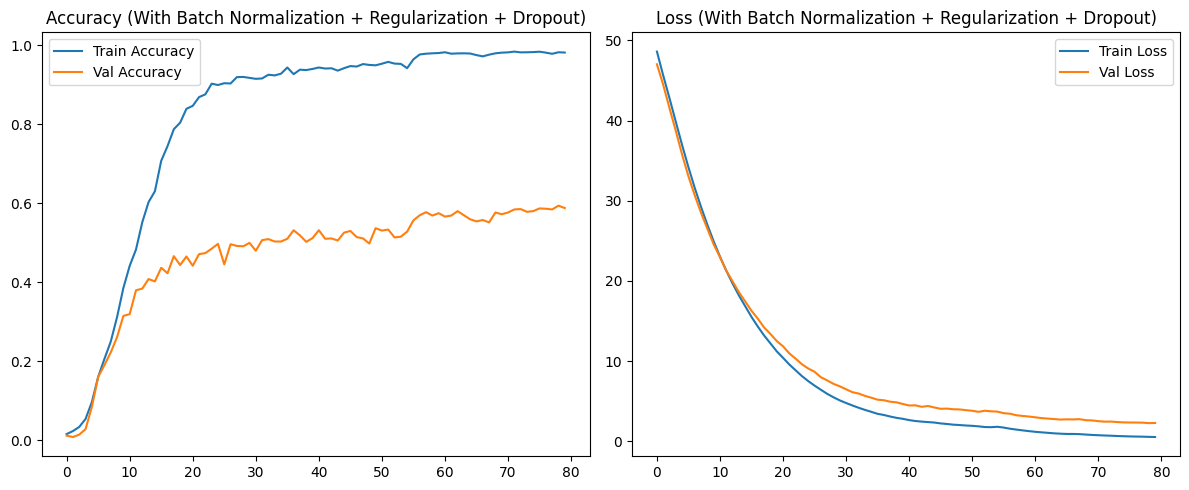

22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step
Accuracy: 0.5881
F1 Score: 0.5733
                               precision    recall  f1-score   support

         adho mukha svanasana       0.88      0.88      0.88         8
        adho mukha vriksasana       0.44      0.57      0.50         7
              agnistambhasana       1.00      0.25      0.40         4
              ananda balasana       0.88      1.00      0.93         7
                   anantasana       0.67      0.80      0.73         5
                 anjaneyasana       0.71      0.62      0.67         8
              ardha bhekasana       0.67      0.50      0.57         4
            ardha chandrasana       0.80      0.67      0.73         6
         ardha matsyendrasana       0.47      0.70      0.56        10
      ardha pincha mayurasana       0.75      1.00      0.86         6
             ardha uttanasana       0.43      0.43      0.43         7
           ashtanga namaskara       0.80      0.80      0.80         5
 

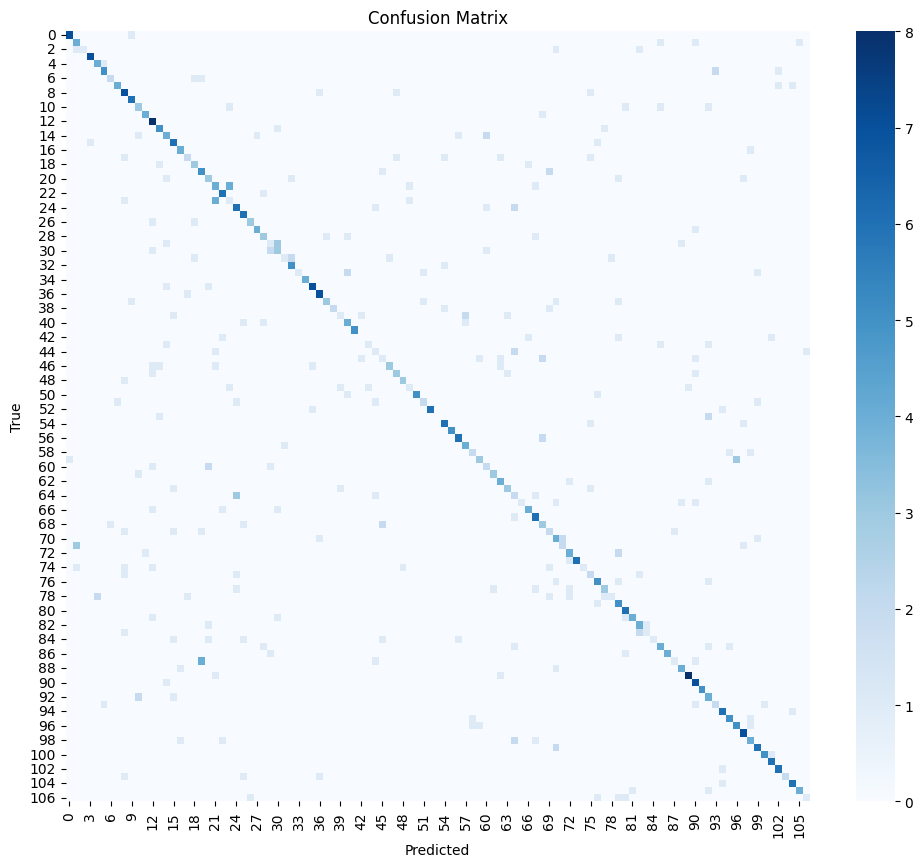

In [37]:
# Add Batch Normalization + Regularization + Dropout
model_bn_reg = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3),
           kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(512, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Conv2D(512, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(512, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Conv2D(512, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Flatten(),
    Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation='softmax')
])

model_bn_reg.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history_bn_reg = model_bn_reg.fit(
    train_gen,
    validation_data=val_gen,
    epochs=80,
    callbacks=callbacks
)
plot_metrics(history_bn_reg, "(With Batch Normalization + Regularization + Dropout)")
acc_bn_reg, f1_bn_reg = evaluate_model(model_bn_reg, test_gen)

In [38]:
#store model results
results = [
    {'Model': 'More Layers', 'Accuracy': round(acc_morelayer, 4), 'F1 Score': round(f1_morelayer, 4)},
    {'Model': 'More Kernels', 'Accuracy': round(acc_morekernel, 4), 'F1 Score': round(f1_morekernel, 4)},
    {'Model': 'Batch Normalization', 'Accuracy': round(acc_bn, 4), 'F1 Score': round(f1_bn, 4)},
    {'Model': 'Regularization', 'Accuracy': round(acc_reg, 4), 'F1 Score': round(f1_reg, 4)},
    {'Model': 'Batch Normalization + Regularization + Dropout', 'Accuracy': round(acc_bn_reg, 4), 'F1 Score': round(f1_bn_reg, 4)}
]

In [39]:
# Convert to DataFrame
df_results = pd.DataFrame(results)
display(df_results)

,Model,Accuracy,F1 Score
0,More Layers,0.3595,0.3300
1,More Kernels,0.4207,0.4090
2,Batch Normalization,0.4410,0.4274
3,Regularization,0.0146,0.0004
4,Batch Normalization + Regularization + Dropout,0.5881,0.5733


### Save the Best Model and Apply Quantization

In [40]:
# save the best model

model.save("model_bn_reg.keras")

In [41]:
import tensorflow as tf

# Load model
model = tf.keras.models.load_model("model_bn_reg.keras")

# Converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Activates post-training quantization

# Convert model
tflite_model = converter.convert()

# Save TFLite model
with open("best_yoga_model_quantized.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpkx364q0_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 107), dtype=tf.float32, name=None)
Captures:
  134628901102288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134628901102480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134628901097104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134628901101520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134628901101712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134628901097488: TensorSpec(shape=(), dtype=tf.resource, name=None)


#### Compare Model Performance

In [42]:
interpreter = tf.lite.Interpreter(model_path="best_yoga_model_quantized.tflite")
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

In [43]:
# Grab a single batch of test images and labels
x_test_batch, y_true_batch = next(test_gen)  # shape: (batch_size, 128, 128, 3)
y_true_indices = np.argmax(y_true_batch, axis=1)

In [44]:
# Predict with original Keras model
y_pred_probs_keras = model_bn_reg.predict(x_test_batch)
y_pred_indices_keras = np.argmax(y_pred_probs_keras, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step


In [45]:
# Function to predict one sample
def predict_tflite_batch(batch):
    predictions = []
    for img in batch:
        img = np.expand_dims(img.astype(np.float32), axis=0)
        interpreter.set_tensor(input_index, img)
        interpreter.invoke()
        output = interpreter.get_tensor(output_index)
        predictions.append(np.argmax(output))
    return np.array(predictions)

y_pred_indices_tflite = predict_tflite_batch(x_test_batch)

In [46]:
# Compare results
from sklearn.metrics import accuracy_score

acc_keras = accuracy_score(y_true_indices, y_pred_indices_keras)
acc_tflite = accuracy_score(y_true_indices, y_pred_indices_tflite)

print(f"Keras Model Accuracy (batch):   {acc_keras:.4f}")
print(f"TFLite Model Accuracy (batch):  {acc_tflite:.4f}")

Keras Model Accuracy (batch):   0.7500
TFLite Model Accuracy (batch):  0.3125


The quantized model performed poorly compared with the kera model.

### Manually Calculate Parameters and Compare

In [48]:
# Manually calculate the total number of parameters
# Block 1
block_1 = (3*3*3 + 1) * 64 + 2*64 + (3*3*64 +1 )*64 + 2*64
print(block_1)

38976


In [49]:
# Block 2
block_2 = (3*3*64 + 1) * 128 + 2*2*128 + (3*3*128 +1 )*128 + 2*2*128
print(block_2)

222464


In [50]:
# Block 3
block_3 = (3*3*128 + 1) * 256 + 2*2*256 + (3*3*256 +1 )*256 + 2*2*256
print(block_3)

887296


In [52]:
# Block 4
block_4 = (3*3*512 + 1) * 512 + 2*2*512 + (3*3*512 +1 )*512 + 2*2*512
print(block_4)

4723712


In [51]:
# Dense Layer
dense = (12*12*512)*1024 + (1024 + 1) * train_gen.num_classes
print(dense)

75607147


In [53]:
total_params = block_1 + block_2 + block_3 + block_4 + dense
print(total_params)

81479595


In [47]:
model_bn_reg.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_52 (Conv2D)              │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 53,736,451 (204.99 MB)

 Trainable params: 17,910,187 (68.32 MB)

 Non-trainable params: 5,888 (23.00 KB)

 Optimizer params: 35,820,376 (136.64 MB)